Here we will create a Rider mean speed feature based on Distance and time from pickup to arrival available in the train dataframe. For the missing values we will build a regression model to predict them.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from geopy import distance
import pickle
from utils_dump_load import load_from_pickle, dump_to_pickle

<h1> EDA

<h2> Loading data

In [2]:
pickle_filename = "data/train_temp.pkl"
df_train = load_from_pickle(pickle_filename)
df_train.shape

(21201, 29)

In [3]:
pickle_filename = "data/test_temp.pkl"
df_test = load_from_pickle(pickle_filename)
df_test.shape

(7068, 25)

filepath_test = "data/Test.csv"
df_test = pd.read_csv(filepath_test, index_col="Order No")
df_test.shape

filepath_train = "data/Train.csv"
df_train = pd.read_csv(filepath_train, index_col="Order No")
df_train.shape

In [4]:
filepath_riders = "data/Riders.csv"
df_riders = pd.read_csv(filepath_riders, index_col="Rider Id")
df_riders.shape

(960, 4)

In [5]:
df_riders.head()

,No_Of_Orders,Age,Average_Rating,No_of_Ratings
Rider Id,,,,
Rider_Id_396,2946,2298,14.0,1159
Rider_Id_479,360,951,13.5,176
Rider_Id_648,1746,821,14.3,466
Rider_Id_753,314,980,12.5,75
Rider_Id_335,536,1113,13.7,156


<h2> Merge data

In [6]:
df_train = df_train.merge(df_riders, left_on='Rider Id', right_on='Rider Id', right_index=True)
df_test = df_test.merge(df_riders, left_on='Rider Id', right_on='Rider Id', right_index=True)

<h2> Compute geopy distance

In [7]:
def compute_distance(row):
    src = (row["Pickup Lat"],row["Pickup Long"])
    dest= (row["Destination Lat"],row["Destination Long"])
    return distance.distance(src,dest).km

In [8]:
df_train["geopy_distance"] = df_train.apply(compute_distance,axis=1)
df_test["geopy_distance"] = df_test.apply(compute_distance,axis=1)

<h2> Compute mean distance

In [9]:
df_train["Distance mean"] = (df_train["Distance (KM)"] + df_train["geopy_distance"])/2
df_test["Distance mean"] = (df_test["Distance (KM)"] + df_test["geopy_distance"])/2

<h2> Compute speed / geospeed

In [10]:
speed_threshold = 100 #Km/h

In [11]:
df_train.head()

,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,...,Destination Long,Rider Id,Time from Pickup to Arrival,Pickup - Hour,No_Of_Orders,Age,Average_Rating,No_of_Ratings,geopy_distance,Distance mean
Order No,,,,,,,,,,,,,,,,,,,,,
Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,9:40:10 AM,...,36.829741,Rider_Id_432,745,10,1637,1309,13.8,549,1.919586,2.959793
Order_No_27440,User_Id_2642,Bike,3,Personal,18,5,3:41:17 PM,18,5,3:41:30 PM,...,36.904295,Rider_Id_432,2886,16,1637,1309,13.8,549,13.367010,16.683505
Order_No_14170,User_Id_3339,Bike,3,Business,31,5,12:51:41 PM,31,5,1:12:49 PM,...,36.818206,Rider_Id_432,2615,13,1637,1309,13.8,549,4.484905,5.242453
Order_No_21727,User_Id_3523,Bike,3,Personal,2,2,7:12:10 AM,2,2,7:12:29 AM,...,36.802061,Rider_Id_432,2986,7,1637,1309,13.8,549,8.903984,13.451992
Order_No_8301,User_Id_87,Bike,2,Personal,22,2,10:40:58 AM,22,2,10:42:24 AM,...,36.752427,Rider_Id_432,1602,10,1637,1309,13.8,549,5.997613,6.498806


In [12]:
df_train["speed"] = (df_train["Distance (KM)"] / df_train["Time from Pickup to Arrival"])*3600
df_train["mean speed"] = (df_train["Distance mean"] / df_train["Time from Pickup to Arrival"])*3600
df_train["geospeed"] = (df_train["geopy_distance"] / df_train["Time from Pickup to Arrival"])*3600

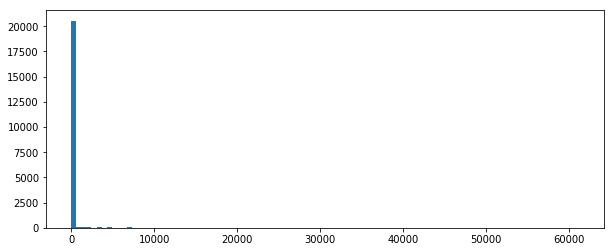

In [13]:
plt.figure(figsize=(10,4))
plt.hist(df_train["speed"], bins=100)
plt.show()

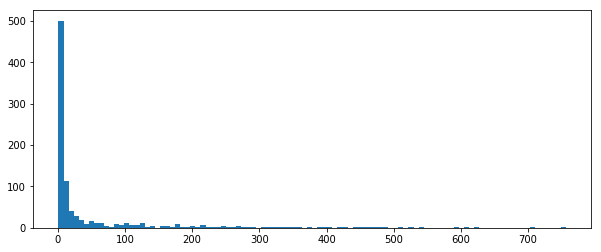

In [14]:
plt.figure(figsize=(10,4))
plt.hist(df_train[df_train["speed"]>speed_threshold]["Time from Pickup to Arrival"], bins=100)
plt.show()

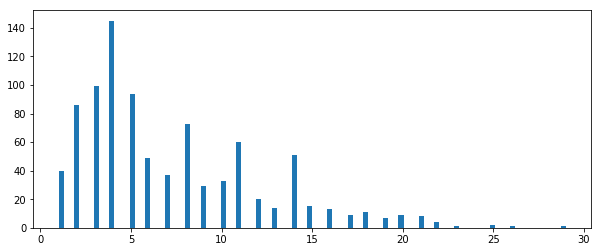

In [15]:
plt.figure(figsize=(10,4))
plt.hist(df_train[df_train["speed"]>speed_threshold]["Distance (KM)"], bins=100)
plt.show()

In [16]:
median_speed = df_train.groupby("Rider Id")["speed"].median()
median_meanspeed = df_train.groupby("Rider Id")["mean speed"].median()
median_geospeed = df_train.groupby("Rider Id")["geospeed"].median()

In [17]:
max_speed = df_train.groupby("Rider Id")["speed"].max()
max_meanspeed = df_train.groupby("Rider Id")["mean speed"].max()
max_geospeed = df_train.groupby("Rider Id")["geospeed"].max()

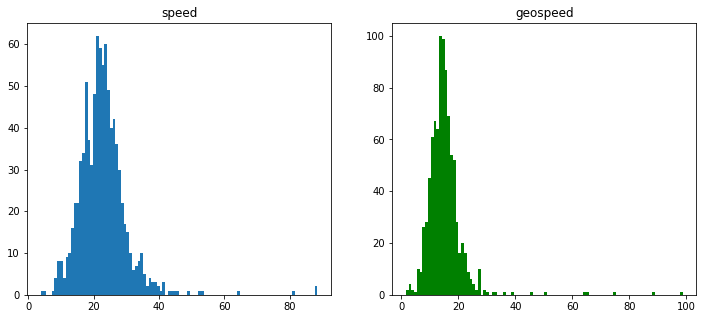

In [18]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.hist(median_speed[median_speed<speed_threshold], bins=100)
plt.title("speed")

#[mean_speed<speed_threshold]

plt.subplot(1, 2, 2)
plt.hist(median_geospeed[median_geospeed<speed_threshold], bins=100, color="g")
plt.title("geospeed")

plt.show()

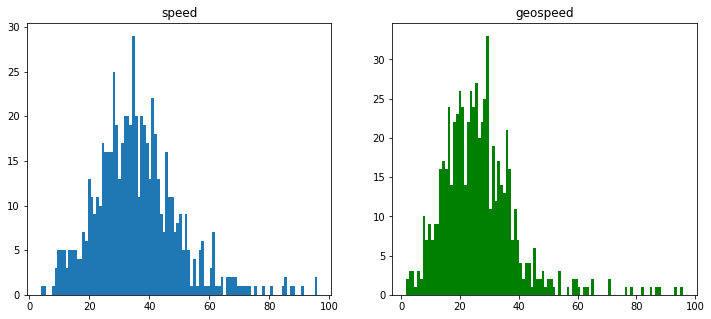

In [21]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.hist(max_speed[max_speed<speed_threshold], bins=100)
plt.title("speed")

#

plt.subplot(1, 2, 2)
plt.hist(max_geospeed[max_geospeed<speed_threshold], bins=100, color="g")
plt.title("geospeed")

plt.show()

In [24]:
len(median_speed[median_speed>speed_threshold])

23

In [26]:
median_riders_speed = df_train["speed"].median()
median_riders_meanspeed = df_train["mean speed"].median()
median_riders_geospeed = df_train["geospeed"].median()
median_riders_speed, median_riders_meanspeed, median_riders_geospeed

(23.064602242391885, 19.005139918013846, 14.922784108433774)

In [28]:
max_riders_speed = df_train["speed"].max()
max_riders_meanspeed = df_train["mean speed"].max()
max_riders_geospeed = df_train["geospeed"].max()
max_riders_speed, max_riders_meanspeed, max_riders_geospeed

(61200.0, 52140.939470921876, 43081.87894184376)

In [37]:
def get_speed(r_id, ref=median_speed):
    try:
        return ref[r_id]
    except:
        return "NaN"

In [38]:
df_riders = df_riders.reset_index()

In [39]:
df_riders["speed"] = df_riders["Rider Id"].apply(lambda x: get_speed(x, median_geospeed))
df_riders["maxspeed"] = df_riders["Rider Id"].apply(lambda x: get_speed(x, max_speed))

In [40]:
df_riders["geospeed"] = df_riders["Rider Id"].apply(lambda x: get_speed(x, median_geospeed))
df_riders["max geospeed"] = df_riders["Rider Id"].apply(lambda x: get_speed(x, max_geospeed))

In [41]:
df_riders["meanspeed"] = df_riders["Rider Id"].apply(lambda x: get_speed(x, median_meanspeed))
df_riders["max meanspeed"] = df_riders["Rider Id"].apply(lambda x: get_speed(x, max_meanspeed))

In [42]:
riders_columns = ['No_Of_Orders', 'Age', 'Average_Rating','No_of_Ratings', 'speed', 'maxspeed', "geospeed", "max geospeed", "meanspeed", "max meanspeed"]
data = df_riders[riders_columns]
df_riders = pd.DataFrame(data.values, index=df_riders["Rider Id"], columns=riders_columns)
df_riders.head()

,No_Of_Orders,Age,Average_Rating,No_of_Ratings,speed,maxspeed,geospeed,max geospeed,meanspeed,max meanspeed
Rider Id,,,,,,,,,,
Rider_Id_396,2946,2298,14,1159,8.86556,29.3279,8.86556,11.4824,17.3664,20.4051
Rider_Id_479,360,951,13.5,176,11.9398,25.4597,11.9398,16.3674,17.354,20.703
Rider_Id_648,1746,821,14.3,466,18.8161,51.7398,18.8161,45.2545,23.2508,48.4972
Rider_Id_753,314,980,12.5,75,13.6807,35.027,13.6807,26.2191,17.6832,30.6231
Rider_Id_335,536,1113,13.7,156,NaN,NaN,NaN,NaN,NaN,NaN


<h1> ML: Speed regression

<h2> Data preparation

In [43]:
targets = ['speed', 'maxspeed', "geospeed", "max geospeed", "meanspeed", "max meanspeed"]

<h3> Create the test set

In [61]:
df_riders_test = df_riders[df_riders["speed"] == "NaN"]

df_y_nan = df_riders_test[targets]
    
X__test = df_riders_test.drop(targets, axis=1)
df_riders_test.shape

(36, 10)

<h3> Create the train set

In [62]:
df_riders_t = df_riders[df_riders["speed"] != "NaN"]

In [63]:
# Integrate a speed threshold
speed_threshold = 100 #km/h
df_riders_train = df_riders_t[df_riders_t["speed"]<speed_threshold]
df_riders_exclude = df_riders_t[df_riders_t["speed"]>speed_threshold]
print("exclude", df_riders_exclude.shape[0], "out of", df_riders_t.shape[0])

exclude 19 out of 924


In [64]:
df_y = df_riders_train[targets]

In [65]:
X = df_riders_train.drop(targets, axis=1)
df_riders_train.shape

(905, 10)

In [104]:
for column in X.columns:
    X[column] = X[column].astype("float")
    X__test[column] = X__test[column].astype("float")

<h2> Building the model

In [105]:
targets

['speed', 'maxspeed', 'geospeed', 'max geospeed', 'meanspeed', 'max meanspeed']

In [106]:
y = df_y["meanspeed"]

In [107]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

In [108]:
from sklearn.linear_model import LinearRegression
from lightgbm.sklearn import LGBMRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

model = XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/home/zyncus/bin/anaconda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [109]:
mean_squared_error(y_pred, y_test)

33.10811730643417

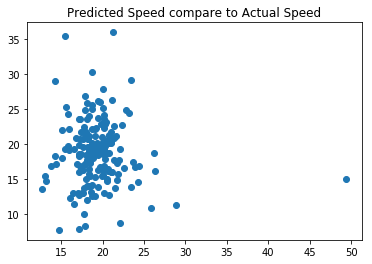

In [110]:
plt.figure()
plt.scatter(y_pred, y_test)
plt.title("Predicted Speed compare to Actual Speed")
plt.show()

<h1> Filling df_riders with speed prediction

In [117]:
df__pred = pd.DataFrame(index = X__test.index)
for target in targets:
    model_s = XGBRegressor()
    model_s.fit(X, df_y[target])
    df__pred[target] = model_s.predict(X__test)

/home/zyncus/bin/anaconda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/zyncus/bin/anaconda/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [119]:
df__pred.head()

,speed,maxspeed,geospeed,max geospeed,meanspeed,max meanspeed
Rider Id,,,,,,
Rider_Id_335,15.052905,887.220459,15.052905,489.519623,19.531078,716.876831
Rider_Id_757,15.602324,1043.676514,15.602324,678.016907,18.606432,1197.502441
Rider_Id_437,15.266510,258.524811,15.266510,234.338715,19.986156,192.160965
Rider_Id_153,14.277929,107.211411,14.277929,47.491917,17.376793,145.216095
Rider_Id_374,15.532578,971.503418,15.532578,458.057312,18.804474,1014.997131


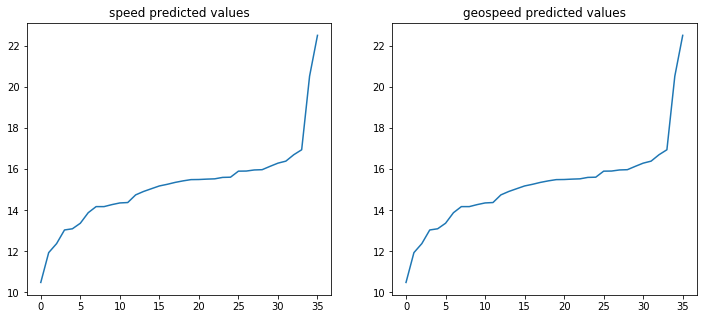

In [120]:
y__speed_pred_s = sorted(df__pred["speed"])
y__geospeed_pred_s = sorted(df__pred["geospeed"])

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(np.arange(len(y__speed_pred_s)), y__speed_pred_s)
plt.title("speed predicted values")

plt.subplot(1, 2, 2)
plt.plot(np.arange(len(y__geospeed_pred_s)), y__geospeed_pred_s)
plt.title("geospeed predicted values")

plt.show()

In [121]:
df__pred = pd.concat([X__test, df__pred], axis=1)
print(df__pred.shape)
df__pred.head()

(36, 10)


,No_Of_Orders,Age,Average_Rating,No_of_Ratings,speed,maxspeed,geospeed,max geospeed,meanspeed,max meanspeed
Rider Id,,,,,,,,,,
Rider_Id_335,536.0,1113.0,13.7,156.0,15.052905,887.220459,15.052905,489.519623,19.531078,716.876831
Rider_Id_757,2101.0,1066.0,12.3,229.0,15.602324,1043.676514,15.602324,678.016907,18.606432,1197.502441
Rider_Id_437,2966.0,2053.0,14.0,1147.0,15.266510,258.524811,15.266510,234.338715,19.986156,192.160965
Rider_Id_153,233.0,982.0,13.9,85.0,14.277929,107.211411,14.277929,47.491917,17.376793,145.216095
Rider_Id_374,1985.0,1191.0,12.3,143.0,15.532578,971.503418,15.532578,458.057312,18.804474,1014.997131


In [122]:
df__riders = pd.concat([df__pred, df_riders_t], axis=0)
print(df__riders.shape)
df__riders.head()

(960, 10)


,No_Of_Orders,Age,Average_Rating,No_of_Ratings,speed,maxspeed,geospeed,max geospeed,meanspeed,max meanspeed
Rider Id,,,,,,,,,,
Rider_Id_335,536,1113,13.7,156,15.0529,887.22,15.0529,489.52,19.5311,716.877
Rider_Id_757,2101,1066,12.3,229,15.6023,1043.68,15.6023,678.017,18.6064,1197.5
Rider_Id_437,2966,2053,14,1147,15.2665,258.525,15.2665,234.339,19.9862,192.161
Rider_Id_153,233,982,13.9,85,14.2779,107.211,14.2779,47.4919,17.3768,145.216
Rider_Id_374,1985,1191,12.3,143,15.5326,971.503,15.5326,458.057,18.8045,1015


In [123]:
df__riders["speed"] = df__riders["speed"].astype("float")
df__riders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 960 entries, Rider_Id_335 to Rider_Id_201
Data columns (total 10 columns):
No_Of_Orders      960 non-null object
Age               960 non-null object
Average_Rating    960 non-null object
No_of_Ratings     960 non-null object
speed             960 non-null float64
maxspeed          960 non-null object
geospeed          960 non-null object
max geospeed      960 non-null object
meanspeed         960 non-null object
max meanspeed     960 non-null object
dtypes: float64(1), object(9)
memory usage: 82.5+ KB


<h2> Dumping to pickle

In [124]:
df__riders.shape

(960, 10)

In [125]:
pickle_filename = "data/riders.pkl"
content = (df__riders)
dump_to_pickle(content, pickle_filename)